Dokonczyc RNN
UNET testowac na innych zbiorach
Transformer
Podstawowe eksperymenty z RSA
Runtime - jak rozwiazac to zagadnienie???
Zestawienie porównania wyników modeli
Latex - zacząć pisać od końca
1. Przeglad aktualnych rozwiazan
2. Implementacja
3. Rezultaty

# RNN for R-peak detection using the pytorch library

In [166]:
import os
import numpy as np
import neurokit2 as nk
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from customLib.vis import *
from customLib.preprocess import *
from customLib.peak_detection import *
from customLib.load_ptbxl import load_ptbxl
from customLib.dataset import *

In [167]:
DATASET_PATH = "./dataset"

LSTM_HIDDEN_SIZE = 32
EPOCHS = 10
BATCH_SIZE = 5
LR = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training will be performed with:',device)

Training will be performed with: cuda:0


In [107]:
x_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_train.npy")), 2)[:10000]
y_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_train.npy")), 2)[:10000] # if conv is used the expand at dim 1

x_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_test.npy")), 2)[:5000]
y_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_test.npy")), 2)[:5000]

x_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_val.npy")), 2)[:1500]
y_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_val.npy")), 2)[:1500]

In [226]:
path = "E:\\ml-data\\masters-thesis\\physionet.org\\files\\mitdb\\1.0.0\\dataset\\expanded_labels\\downsampled"
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(path=path, is_validation_set=True)

In [227]:
x_train = np.expand_dims(x_train, 2)
y_train = np.expand_dims(y_train, 2)

x_test = np.expand_dims(x_test, 2)
y_test = np.expand_dims(y_test, 2)

x_val = np.expand_dims(x_val, 2)
y_val = np.expand_dims(y_val, 2)

In [86]:
### mitbih only ecgs, labeled automatically

In [2]:
from customLib.create_dataset import label_ecgs

In [87]:
x = np.load("E:\\ml-data\\masters-thesis\\physionet.org\\files\\mitdb\\1.0.0\\preprocessed\\x.npy")
x, y = label_ecgs(ecgs=x, sampling_rate=360)
x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(x=x, y=y, is_validation_set=True, shuffle=True)

Total ECGs: 15840


100%|██████████| 15840/15840 [00:18<00:00, 870.76it/s]
c:\Users\patry\OneDrive\Elearning - PG\WETI\semestr III\OSIOSN\projekt\customLib\dataset.py:33: UserWarning: Path is not specified. The dataset is not being saved.
  warnings.warn("Path is not specified. The dataset is not being saved.")


Total ECGs: 15840


In [170]:
class ECGDataset(Dataset):
  def __init__(self, data, labels):
    super(ECGDataset, self).__init__()
    self.data = data
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32)
    label = torch.tensor(self.labels[idx], dtype=torch.float32)
    return sample, label

In [171]:
class WeightedBCELoss(torch.nn.Module):
  def __init__(self, negative_weight=None, positive_weight=None):
    super(WeightedBCELoss, self).__init__()
    self.w_n = negative_weight
    self.w_p = positive_weight

  def forward(self, prediction, ground_truth, epsilon=1e-7):
    if self.w_n is None or self.w_p is None:
        # Calculate weights for the current batch
        pos_weight = (ground_truth == 1).float().sum()
        neg_weight = (ground_truth == 0).float().sum()
        total = pos_weight + neg_weight
        self.w_p = neg_weight / total
        self.w_n = pos_weight / total
        print("Positive weights: ", self.w_p)
        print("Negative weights: ", self.w_p)
    
    loss_pos = -1 * self.w_p * (ground_truth * torch.log(prediction + epsilon)).mean()
    loss_neg = -1 * self.w_n * ((1 - ground_truth) * torch.log(1 - prediction + epsilon)).mean()
  
    return loss_pos + loss_neg


In [229]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_size, lr=1e-2, loss_pos_weight=None):
        super(LSTM, self).__init__()
        self.lstm_1 = torch.nn.LSTM(input_size=input_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True, dropout=0.3)
        self.lstm_2 = torch.nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.tangent = torch.nn.Tanh()

        # achieveing better results with Dense layer instead of Conv1d as an output layer and when dropout is used after lstm instead of Dense layer
        #self.conv = torch.nn.Conv1d(in_channels=hidden_size, out_channels=1, kernel_size=1, padding="same")
        #self.relu = torch.nn.ReLU()
        
        self.dense = torch.nn.Linear(in_features=2*hidden_size, out_features=1)
        # self.sigmoid = torch.nn.Sigmoid()

        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=loss_pos_weight) # WeightedBCELoss() # torch.nn.BCELoss()
        self.optimizer = Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x = self.tangent(x)

        x, _ = self.lstm_2(x)
        x = self.tangent(x)

        x = self.dense(x)
        # output = self.sigmoid(x) 
        return x
    
    def train_model(self, x_train, y_train, epochs=10, batch_size=1, x_val=None, y_val=None,):
        self.batch_size = batch_size
        dataset = ECGDataset(x_train, y_train)
        train_loader = DataLoader(dataset, batch_size, shuffle=False)

        if x_val is not None:
            validation_dataset = ECGDataset(x_val, y_val)
            validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            print(f"====Epoch [{epoch + 1}/{epochs}]====")
            running_loss = 0.0
            num_r_peaks = 0.0
            num_correct = 0.0

            all_outputs = []
            all_labels = []
            
            self.train()
            for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
                x, y = x.to(device), y.to(device)

                self.optimizer.zero_grad()
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_loss += loss.item()

                loss.backward()
                self.optimizer.step()

                outputs = torch.sigmoid(outputs)
                outputs = outputs.cpu().detach().numpy()
                y = y.cpu().detach().numpy()

                num_r_peaks += np.where(y == 1)[0].shape[0]
                num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

                all_outputs.extend(outputs.flatten())
                all_labels.extend(y.flatten())

                if i == len(train_loader) - 1:
                    randIdx = np.random.randint(low=0, high=x.shape[0])
                    plt.figure()
                    plt.title(f"Last batch, sample number {randIdx + 1}")
                    plt.plot(x[randIdx].cpu().detach().numpy().flatten(), 'b-')
                    plt.plot(y[randIdx].flatten(), 'g-')
                    plt.plot(outputs[randIdx].flatten(), 'r--')
                    plt.legend(["ECG", "Ground Truth", "Prediction"])
                    plt.show()
            
            all_outputs = np.array(all_outputs)
            all_labels = np.array(all_labels)
            y_pred_binary = (all_outputs > 0.5).astype(int)

            
            print(f"\nTrain Loss: {running_loss / len(train_loader):.4f}")
            self.calculate_metrics(all_labels, y_pred_binary, phase="Train")
        
            if x_val is not None:
                self.validate(validation_loader)
  
    def validate(self, validation_loader):
        self.eval()
        running_vloss = 0.0
        num_r_peaks = 0.0
        num_correct = 0.0

        all_outputs = []
        all_labels = []

        with torch.no_grad():
            for i, (x_val, y_val) in tqdm(enumerate(validation_loader), total=len(validation_loader)):
                x, y = x_val.to(device), y_val.to(device)
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_vloss += loss.item()

                outputs = torch.sigmoid(outputs)
                outputs = outputs.cpu().detach().numpy()
                y = y.cpu().detach().numpy()

                num_r_peaks += np.where(y == 1)[0].shape[0]
                num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

                all_outputs.extend(outputs.flatten())
                all_labels.extend(y.flatten())

            all_outputs = np.array(all_outputs)
            all_labels = np.array(all_labels)
            y_pred_binary = (all_outputs > 0.5).astype(int)

            print(f"\nValidation Loss: {running_vloss / len(validation_loader):.4f}")
            self.calculate_metrics(all_labels, y_pred_binary, phase="Validation")
    
    def test_model(self, x_test, y_test, plot=False):
        test_dataset = ECGDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        
        running_loss = 0.0
        num_r_peaks = 0.0
        num_correct = 0.0

        all_outputs = []
        all_labels = []
        
        self.eval()
        with torch.no_grad():
            for i, (x_test, y_test) in tqdm(enumerate(test_loader), total=len(test_loader)):
                x, y = x_test.to(device), y_test.to(device)
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_loss += loss.item()

                outputs = torch.sigmoid(outputs)
                outputs = outputs.cpu().detach().numpy()
                y = y.cpu().detach().numpy()

                num_r_peaks += np.where(y == 1)[0].shape[0]
                num_correct += np.where((outputs > 0.5) & (y == 1))[0].shape[0]

                all_outputs.extend(outputs.flatten())
                all_labels.extend(y.flatten())

                if plot and (i % int(len(test_loader) / 10) == 0):
                    ecg = x[0].cpu().detach().numpy()
                    gt = y[0]
                    pred = outputs[0]

                    plt.figure()
                    plt.plot(ecg)
                    plt.plot(gt)
                    plt.plot(pred)
                    plt.legend(["ECG", "Ground Truth", "Prediction"])
                    plt.grid()
                    plt.show()
                
        all_outputs = np.array(all_outputs)
        all_labels = np.array(all_labels)
        y_pred_binary = (all_outputs > 0.5).astype(int)

        print(f"\nTest Loss: {running_loss / len(test_loader):.4f}")
        self.calculate_metrics(all_labels, y_pred_binary, phase="Test")
    
    # we only care about the precision of the R_peaks (binary class 1) and we about the false positive rate
    def calculate_metrics(self, y_true, y_pred_binary, phase="Train"):
        total_targets = y_true.shape[0]
        positive_count = np.sum(y_true)
        negative_count = total_targets - positive_count
        w_p = negative_count / total_targets
        w_n = positive_count / total_targets

        weights = [ w_p if x == 1 else w_n for x in y_true ]

        accuracy = balanced_accuracy_score(y_true=y_true, y_pred=y_pred_binary, sample_weight=weights)
        
        f1 = f1_score(y_true, y_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        print(f"{phase} Weighted Accuracy: {accuracy:.5f}")
        print(f"{phase} F1 Score: {f1:.5f}")
        print(f"{phase} TPR: {tpr:.5f}")
        print(f"{phase} FPR: {fpr:.5f}")
        print(f"{phase} TNR: {tnr:.5f}")
        print(f"{phase} FNR: {fnr:.5f}\n")
        

In [230]:
num_pos = np.sum(y_train[0])
num_neg = len(y_train[0]) - num_pos
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
print(f"Positive label weight (R-peak): {pos_weight.item():.5f}")

Positive label weight (R-peak): 33.48276


In [231]:
model = LSTM(input_dim=1, hidden_size=32, lr=1e-2, loss_pos_weight=pos_weight) #input_size == hidden features size (1-lead ECG)
model.to(device)

e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm_1): LSTM(1, 32, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm_2): LSTM(64, 32, batch_first=True, bidirectional=True)
  (tangent): Tanh()
  (dense): Linear(in_features=64, out_features=1, bias=True)
  (criterion): BCEWithLogitsLoss()
)

====Epoch [1/20]====


100%|█████████▉| 237/238 [00:07<00:00, 32.17it/s]

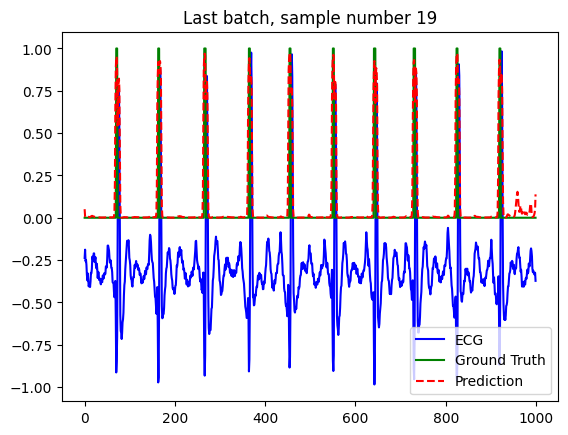

100%|██████████| 238/238 [00:08<00:00, 29.31it/s]



Train Loss: 0.3967
Train Weighted Accuracy: 0.91866
Train F1 Score: 0.40866
Train TPR: 0.96502
Train FPR: 0.12771
Train TNR: 0.87229
Train FNR: 0.03498



100%|██████████| 40/40 [00:00<00:00, 40.11it/s]



Validation Loss: 0.2050
Validation Weighted Accuracy: 0.96860
Validation F1 Score: 0.64813
Validation TPR: 0.98578
Validation FPR: 0.04857
Validation TNR: 0.95143
Validation FNR: 0.01422

====Epoch [2/20]====


 99%|█████████▊| 235/238 [00:10<00:00, 24.57it/s]

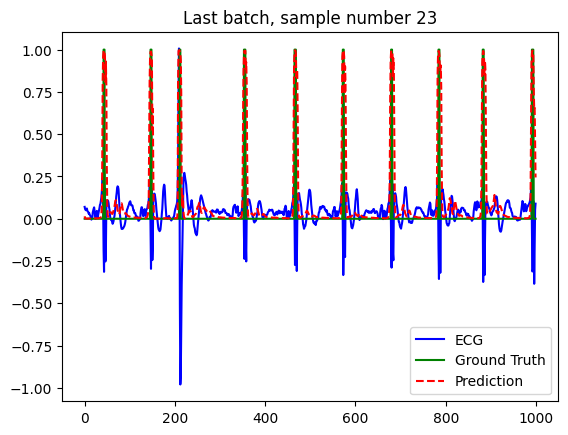

100%|██████████| 238/238 [00:10<00:00, 22.33it/s]



Train Loss: 0.1894
Train Weighted Accuracy: 0.97154
Train F1 Score: 0.67325
Train TPR: 0.98682
Train FPR: 0.04375
Train TNR: 0.95625
Train FNR: 0.01318



100%|██████████| 40/40 [00:00<00:00, 40.97it/s]



Validation Loss: 0.1726
Validation Weighted Accuracy: 0.97434
Validation F1 Score: 0.69247
Validation TPR: 0.98853
Validation FPR: 0.03985
Validation TNR: 0.96015
Validation FNR: 0.01147

====Epoch [3/20]====


 99%|█████████▊| 235/238 [00:10<00:00, 24.37it/s]

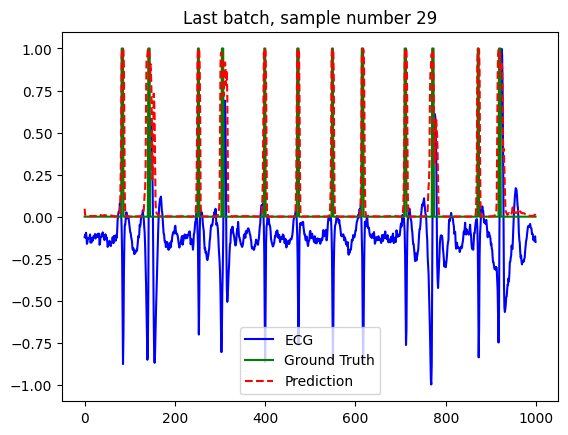

100%|██████████| 238/238 [00:10<00:00, 22.80it/s]



Train Loss: 0.1627
Train Weighted Accuracy: 0.97562
Train F1 Score: 0.70536
Train TPR: 0.98900
Train FPR: 0.03775
Train TNR: 0.96225
Train FNR: 0.01100



100%|██████████| 40/40 [00:01<00:00, 39.94it/s]



Validation Loss: 0.1540
Validation Weighted Accuracy: 0.97672
Validation F1 Score: 0.72407
Validation TPR: 0.98748
Validation FPR: 0.03404
Validation TNR: 0.96596
Validation FNR: 0.01252

====Epoch [4/20]====


100%|█████████▉| 237/238 [00:10<00:00, 29.01it/s]

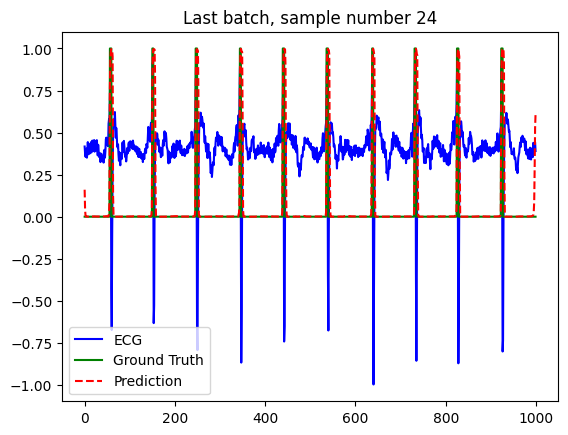

100%|██████████| 238/238 [00:10<00:00, 22.77it/s]



Train Loss: 0.1443
Train Weighted Accuracy: 0.97831
Train F1 Score: 0.72925
Train TPR: 0.99021
Train FPR: 0.03360
Train TNR: 0.96640
Train FNR: 0.00979



100%|██████████| 40/40 [00:00<00:00, 41.94it/s]



Validation Loss: 0.1613
Validation Weighted Accuracy: 0.97530
Validation F1 Score: 0.69836
Validation TPR: 0.98943
Validation FPR: 0.03882
Validation TNR: 0.96118
Validation FNR: 0.01057

====Epoch [5/20]====


100%|█████████▉| 237/238 [00:08<00:00, 28.70it/s]

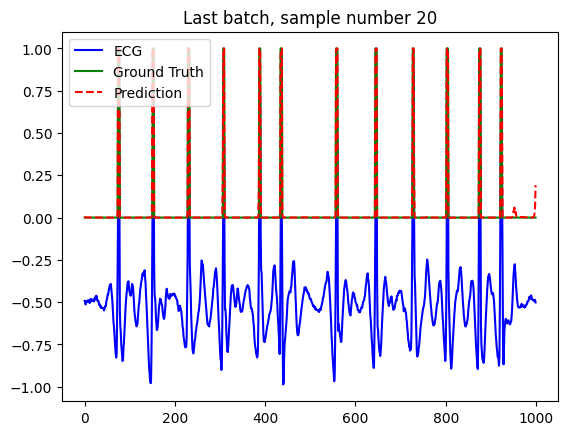

100%|██████████| 238/238 [00:09<00:00, 25.93it/s]



Train Loss: 0.1371
Train Weighted Accuracy: 0.97924
Train F1 Score: 0.74080
Train TPR: 0.99012
Train FPR: 0.03163
Train TNR: 0.96837
Train FNR: 0.00988



100%|██████████| 40/40 [00:00<00:00, 49.09it/s]



Validation Loss: 0.1373
Validation Weighted Accuracy: 0.97959
Validation F1 Score: 0.76331
Validation TPR: 0.98671
Validation FPR: 0.02753
Validation TNR: 0.97247
Validation FNR: 0.01329

====Epoch [6/20]====


100%|█████████▉| 237/238 [00:08<00:00, 27.63it/s]

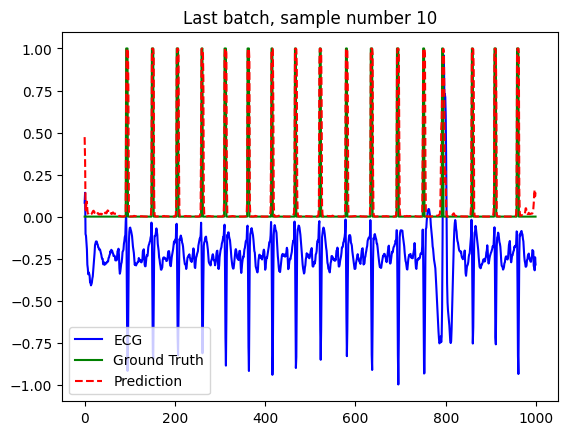

100%|██████████| 238/238 [00:09<00:00, 25.60it/s]



Train Loss: 0.1499
Train Weighted Accuracy: 0.97736
Train F1 Score: 0.72728
Train TPR: 0.98852
Train FPR: 0.03380
Train TNR: 0.96620
Train FNR: 0.01148



100%|██████████| 40/40 [00:01<00:00, 36.83it/s]



Validation Loss: 0.1238
Validation Weighted Accuracy: 0.98133
Validation F1 Score: 0.75950
Validation TPR: 0.99111
Validation FPR: 0.02846
Validation TNR: 0.97154
Validation FNR: 0.00889

====Epoch [7/20]====


 99%|█████████▊| 235/238 [00:10<00:00, 23.89it/s]

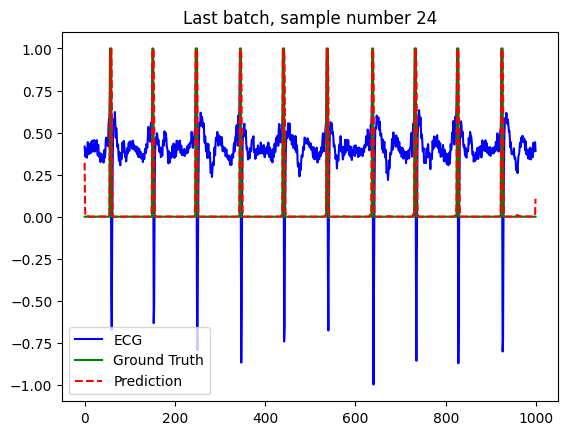

100%|██████████| 238/238 [00:11<00:00, 21.50it/s]



Train Loss: 0.1164
Train Weighted Accuracy: 0.98234
Train F1 Score: 0.77185
Train TPR: 0.99141
Train FPR: 0.02674
Train TNR: 0.97326
Train FNR: 0.00859



100%|██████████| 40/40 [00:00<00:00, 48.32it/s]



Validation Loss: 0.1087
Validation Weighted Accuracy: 0.98333
Validation F1 Score: 0.77629
Validation TPR: 0.99263
Validation FPR: 0.02597
Validation TNR: 0.97403
Validation FNR: 0.00737

====Epoch [8/20]====


 99%|█████████▊| 235/238 [00:10<00:00, 24.91it/s]

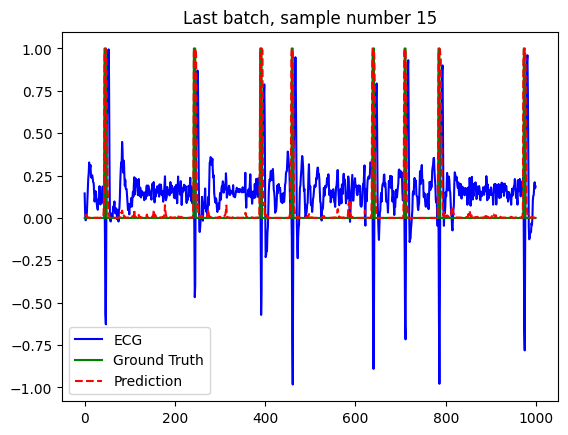

100%|██████████| 238/238 [00:10<00:00, 21.69it/s]



Train Loss: 0.1072
Train Weighted Accuracy: 0.98372
Train F1 Score: 0.78599
Train TPR: 0.99210
Train FPR: 0.02465
Train TNR: 0.97535
Train FNR: 0.00790



100%|██████████| 40/40 [00:00<00:00, 47.26it/s]



Validation Loss: 0.1098
Validation Weighted Accuracy: 0.98333
Validation F1 Score: 0.78223
Validation TPR: 0.99166
Validation FPR: 0.02501
Validation TNR: 0.97499
Validation FNR: 0.00834

====Epoch [9/20]====


 99%|█████████▊| 235/238 [00:10<00:00, 24.44it/s]

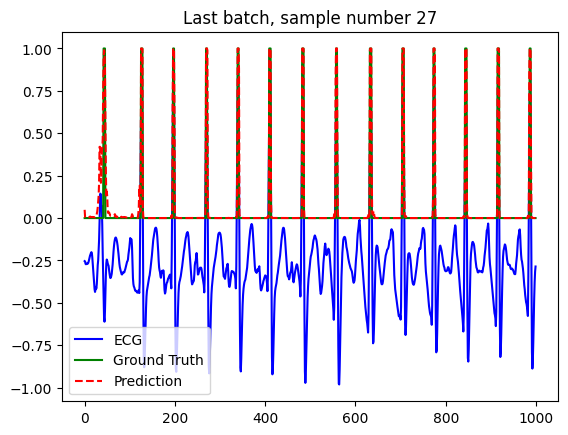

100%|██████████| 238/238 [00:10<00:00, 22.39it/s]



Train Loss: 0.1003
Train Weighted Accuracy: 0.98472
Train F1 Score: 0.79704
Train TPR: 0.99250
Train FPR: 0.02306
Train TNR: 0.97694
Train FNR: 0.00750



100%|██████████| 40/40 [00:00<00:00, 44.88it/s]



Validation Loss: 0.0998
Validation Weighted Accuracy: 0.98494
Validation F1 Score: 0.79812
Validation TPR: 0.99264
Validation FPR: 0.02276
Validation TNR: 0.97724
Validation FNR: 0.00736

====Epoch [10/20]====


 99%|█████████▊| 235/238 [00:07<00:00, 28.44it/s]

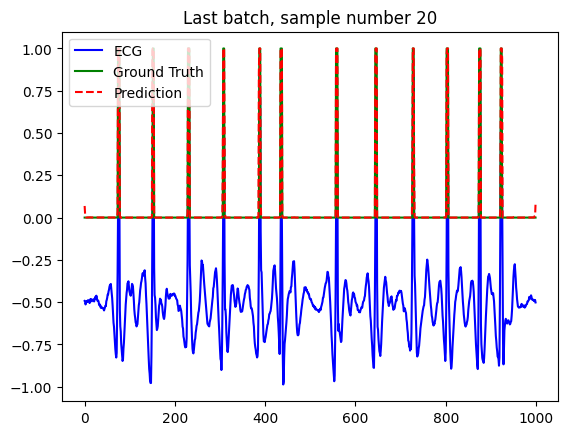

100%|██████████| 238/238 [00:08<00:00, 28.95it/s]



Train Loss: 0.0967
Train Weighted Accuracy: 0.98529
Train F1 Score: 0.80375
Train TPR: 0.99269
Train FPR: 0.02211
Train TNR: 0.97789
Train FNR: 0.00731



100%|██████████| 40/40 [00:00<00:00, 46.55it/s]



Validation Loss: 0.1020
Validation Weighted Accuracy: 0.98456
Validation F1 Score: 0.79339
Validation TPR: 0.99255
Validation FPR: 0.02343
Validation TNR: 0.97657
Validation FNR: 0.00745

====Epoch [11/20]====


 99%|█████████▊| 235/238 [00:08<00:00, 28.67it/s]

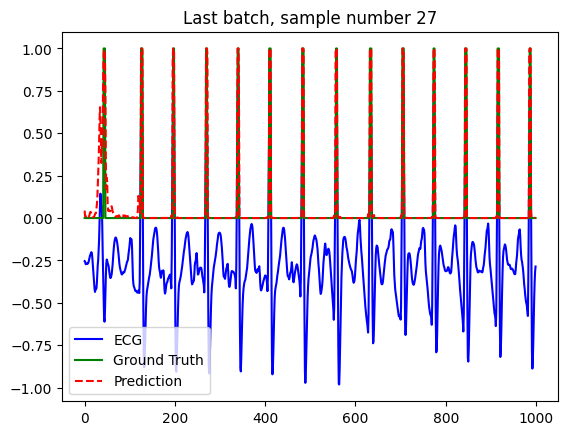

100%|██████████| 238/238 [00:09<00:00, 25.63it/s]



Train Loss: 0.0968
Train Weighted Accuracy: 0.98533
Train F1 Score: 0.80461
Train TPR: 0.99264
Train FPR: 0.02198
Train TNR: 0.97802
Train FNR: 0.00736



100%|██████████| 40/40 [00:00<00:00, 46.42it/s]



Validation Loss: 0.0913
Validation Weighted Accuracy: 0.98641
Validation F1 Score: 0.81812
Validation TPR: 0.99279
Validation FPR: 0.01997
Validation TNR: 0.98003
Validation FNR: 0.00721

====Epoch [12/20]====


100%|█████████▉| 237/238 [00:08<00:00, 28.09it/s]

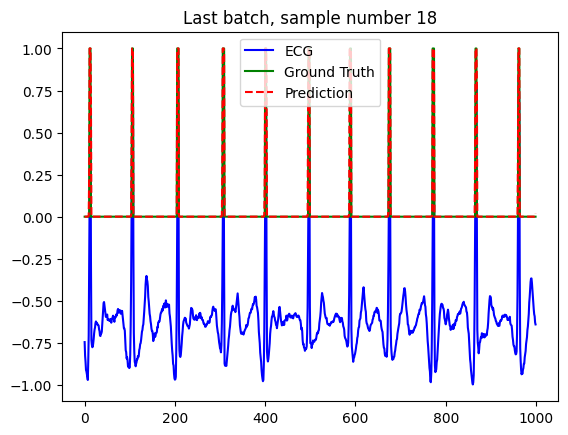

100%|██████████| 238/238 [00:09<00:00, 25.54it/s]



Train Loss: 0.0876
Train Weighted Accuracy: 0.98671
Train F1 Score: 0.81862
Train TPR: 0.99350
Train FPR: 0.02009
Train TNR: 0.97991
Train FNR: 0.00650



100%|██████████| 40/40 [00:00<00:00, 41.46it/s]



Validation Loss: 0.0882
Validation Weighted Accuracy: 0.98703
Validation F1 Score: 0.82744
Validation TPR: 0.99278
Validation FPR: 0.01871
Validation TNR: 0.98129
Validation FNR: 0.00722

====Epoch [13/20]====


 99%|█████████▊| 235/238 [00:11<00:00, 21.75it/s]

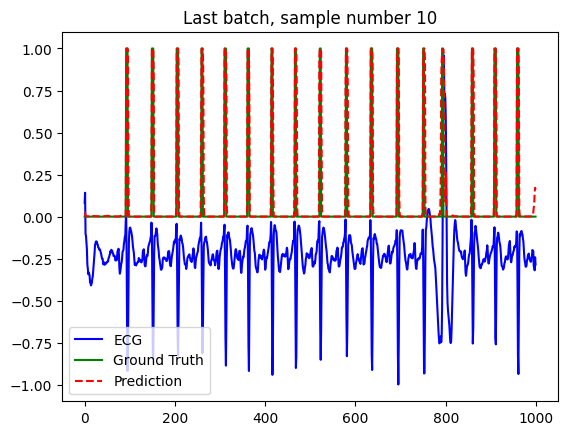

100%|██████████| 238/238 [00:11<00:00, 19.84it/s]



Train Loss: 0.0847
Train Weighted Accuracy: 0.98719
Train F1 Score: 0.82373
Train TPR: 0.99380
Train FPR: 0.01941
Train TNR: 0.98059
Train FNR: 0.00620



100%|██████████| 40/40 [00:01<00:00, 36.51it/s]



Validation Loss: 0.0913
Validation Weighted Accuracy: 0.98626
Validation F1 Score: 0.82038
Validation TPR: 0.99214
Validation FPR: 0.01962
Validation TNR: 0.98038
Validation FNR: 0.00786

====Epoch [14/20]====


100%|█████████▉| 237/238 [00:09<00:00, 33.10it/s]

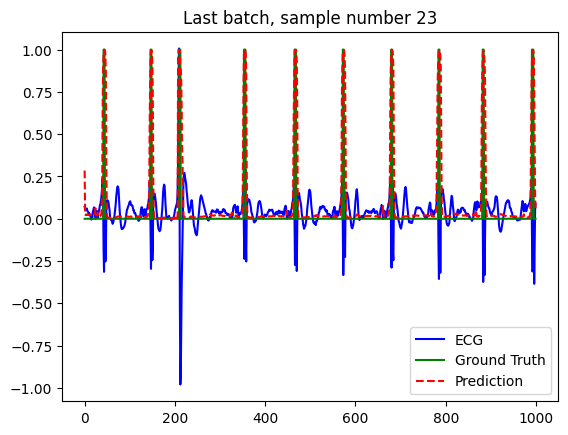

100%|██████████| 238/238 [00:09<00:00, 24.92it/s]



Train Loss: 0.2170
Train Weighted Accuracy: 0.96697
Train F1 Score: 0.65092
Train TPR: 0.98187
Train FPR: 0.04793
Train TNR: 0.95207
Train FNR: 0.01813



100%|██████████| 40/40 [00:00<00:00, 52.22it/s]



Validation Loss: 0.2170
Validation Weighted Accuracy: 0.96874
Validation F1 Score: 0.67904
Validation TPR: 0.97908
Validation FPR: 0.04161
Validation TNR: 0.95839
Validation FNR: 0.02092

====Epoch [15/20]====


100%|█████████▉| 237/238 [00:06<00:00, 30.97it/s]

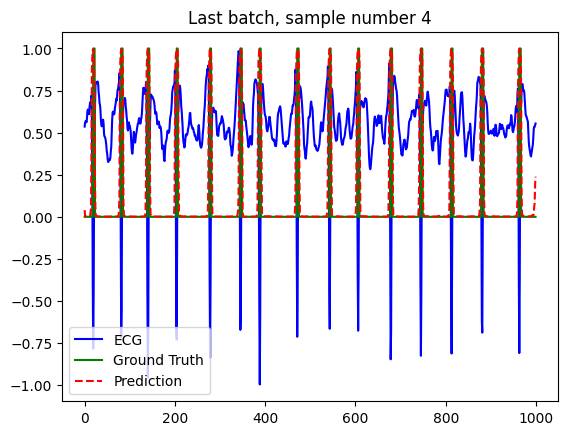

100%|██████████| 238/238 [00:07<00:00, 31.94it/s]



Train Loss: 0.1921
Train Weighted Accuracy: 0.97146
Train F1 Score: 0.67240
Train TPR: 0.98684
Train FPR: 0.04392
Train TNR: 0.95608
Train FNR: 0.01316



100%|██████████| 40/40 [00:00<00:00, 44.09it/s]



Validation Loss: 0.1673
Validation Weighted Accuracy: 0.97421
Validation F1 Score: 0.68800
Validation TPR: 0.98918
Validation FPR: 0.04076
Validation TNR: 0.95924
Validation FNR: 0.01082

====Epoch [16/20]====


 99%|█████████▉| 236/238 [00:08<00:00, 28.12it/s]

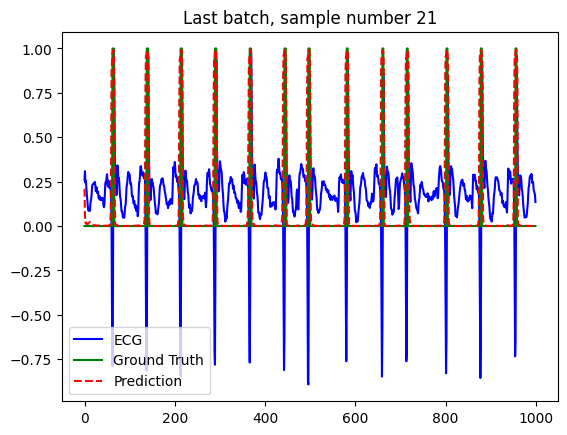

100%|██████████| 238/238 [00:09<00:00, 25.82it/s]



Train Loss: 0.1639
Train Weighted Accuracy: 0.97528
Train F1 Score: 0.70440
Train TPR: 0.98843
Train FPR: 0.03788
Train TNR: 0.96212
Train FNR: 0.01157



100%|██████████| 40/40 [00:00<00:00, 42.13it/s]



Validation Loss: 0.1482
Validation Weighted Accuracy: 0.97768
Validation F1 Score: 0.72055
Validation TPR: 0.99023
Validation FPR: 0.03487
Validation TNR: 0.96513
Validation FNR: 0.00977

====Epoch [17/20]====


 98%|█████████▊| 234/238 [00:08<00:00, 27.76it/s]

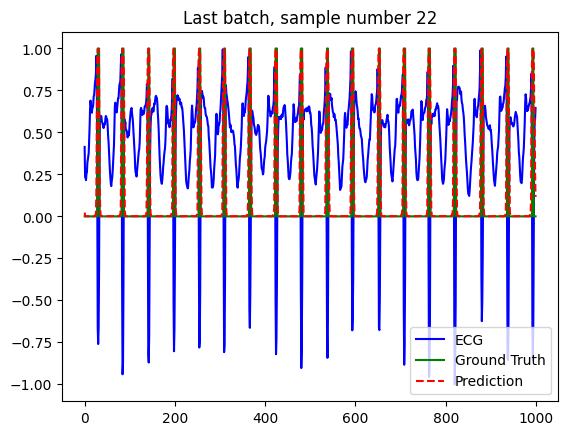

100%|██████████| 238/238 [00:09<00:00, 26.32it/s]



Train Loss: 0.1473
Train Weighted Accuracy: 0.97790
Train F1 Score: 0.72916
Train TPR: 0.98934
Train FPR: 0.03354
Train TNR: 0.96646
Train FNR: 0.01066



100%|██████████| 40/40 [00:01<00:00, 31.80it/s]



Validation Loss: 0.1346
Validation Weighted Accuracy: 0.97969
Validation F1 Score: 0.73897
Validation TPR: 0.99118
Validation FPR: 0.03180
Validation TNR: 0.96820
Validation FNR: 0.00882

====Epoch [18/20]====


 99%|█████████▉| 236/238 [00:09<00:00, 26.93it/s]

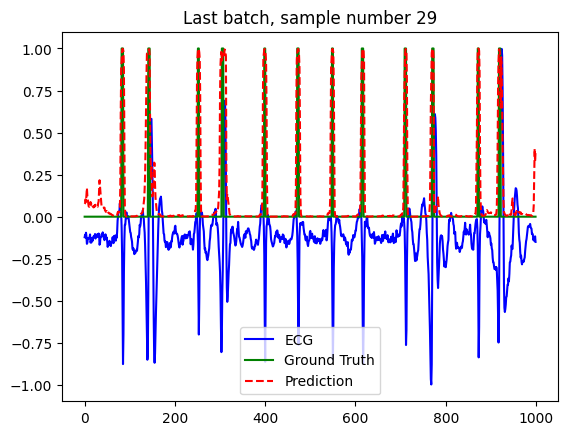

100%|██████████| 238/238 [00:09<00:00, 24.46it/s]



Train Loss: 0.1346
Train Weighted Accuracy: 0.97978
Train F1 Score: 0.74774
Train TPR: 0.99004
Train FPR: 0.03047
Train TNR: 0.96953
Train FNR: 0.00996



100%|██████████| 40/40 [00:00<00:00, 44.53it/s]



Validation Loss: 0.1284
Validation Weighted Accuracy: 0.98067
Validation F1 Score: 0.75391
Validation TPR: 0.99066
Validation FPR: 0.02932
Validation TNR: 0.97068
Validation FNR: 0.00934

====Epoch [19/20]====


 99%|█████████▉| 236/238 [00:08<00:00, 27.14it/s]

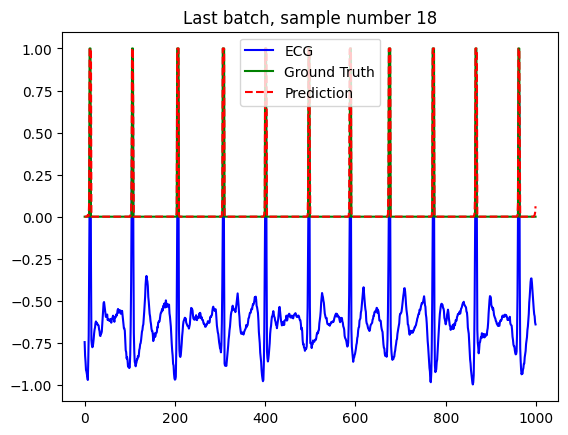

100%|██████████| 238/238 [00:09<00:00, 26.10it/s]



Train Loss: 0.1264
Train Weighted Accuracy: 0.98092
Train F1 Score: 0.75931
Train TPR: 0.99049
Train FPR: 0.02864
Train TNR: 0.97136
Train FNR: 0.00951



100%|██████████| 40/40 [00:00<00:00, 44.02it/s]



Validation Loss: 0.1344
Validation Weighted Accuracy: 0.98032
Validation F1 Score: 0.76282
Validation TPR: 0.98836
Validation FPR: 0.02773
Validation TNR: 0.97227
Validation FNR: 0.01164

====Epoch [20/20]====


 99%|█████████▊| 235/238 [00:08<00:00, 28.24it/s]

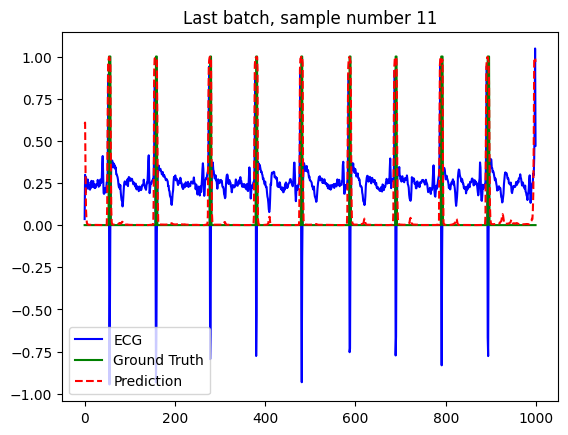

100%|██████████| 238/238 [00:09<00:00, 26.01it/s]



Train Loss: 0.1268
Train Weighted Accuracy: 0.98087
Train F1 Score: 0.75993
Train TPR: 0.99027
Train FPR: 0.02852
Train TNR: 0.97148
Train FNR: 0.00973



100%|██████████| 40/40 [00:00<00:00, 48.86it/s]



Validation Loss: 0.1426
Validation Weighted Accuracy: 0.97790
Validation F1 Score: 0.71068
Validation TPR: 0.99263
Validation FPR: 0.03683
Validation TNR: 0.96317
Validation FNR: 0.00737



In [232]:
model.train_model(x_train=x_train, y_train=y_train, epochs=20, x_val=x_val, y_val=y_val, batch_size=50)

  0%|          | 0/396 [00:00<?, ?it/s]

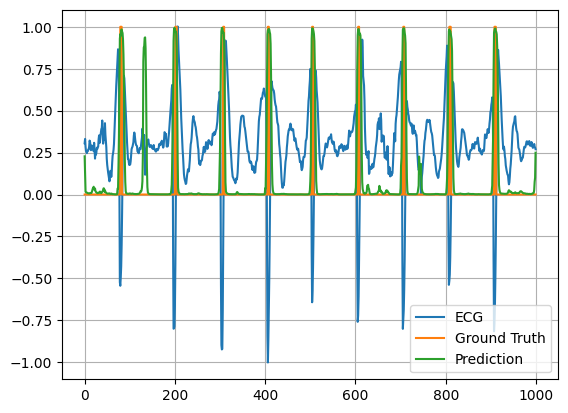

 10%|▉         | 38/396 [00:00<00:04, 75.62it/s]

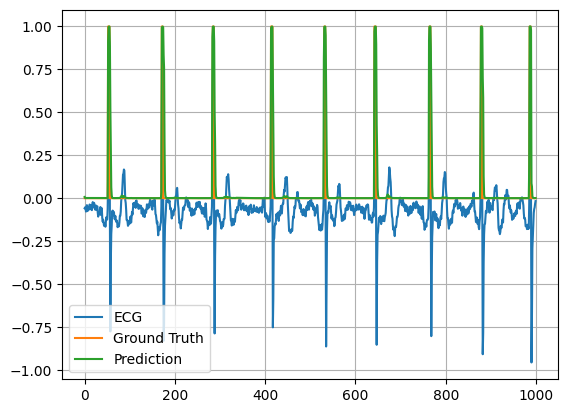

 18%|█▊        | 72/396 [00:01<00:04, 74.29it/s]

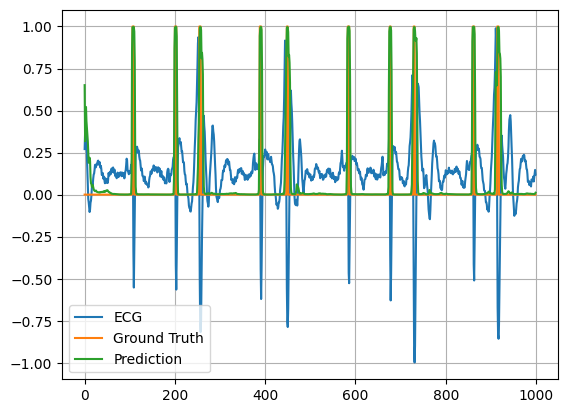

 29%|██▉       | 116/396 [00:01<00:03, 87.64it/s]

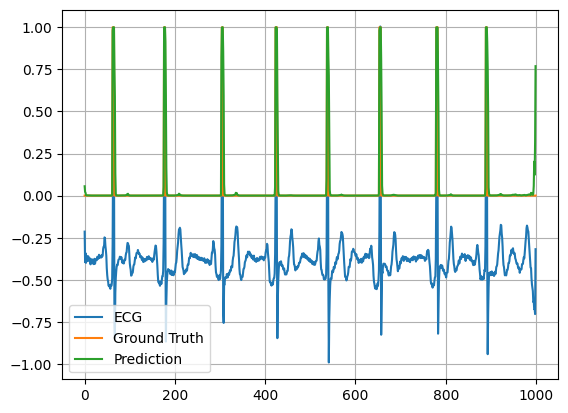

 38%|███▊      | 152/396 [00:02<00:02, 92.50it/s]

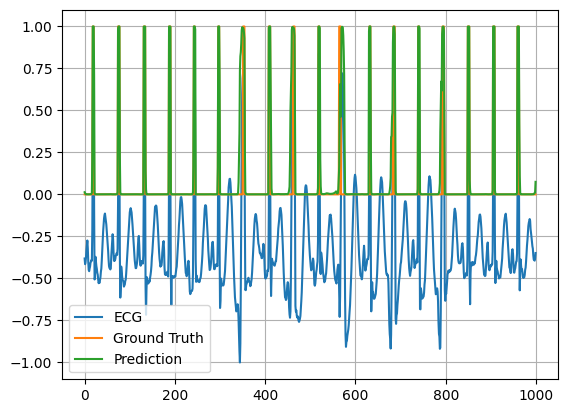

 47%|████▋     | 188/396 [00:03<00:03, 62.71it/s]

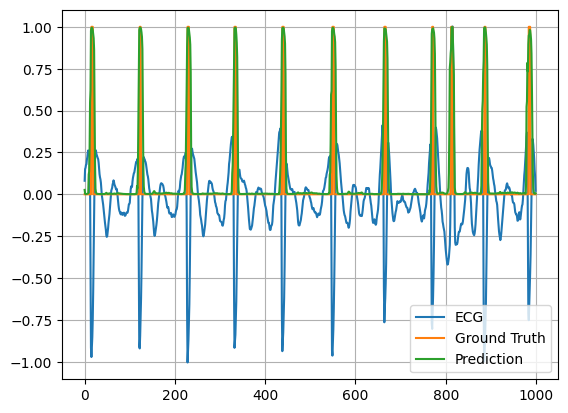

 57%|█████▋    | 224/396 [00:03<00:02, 78.67it/s]

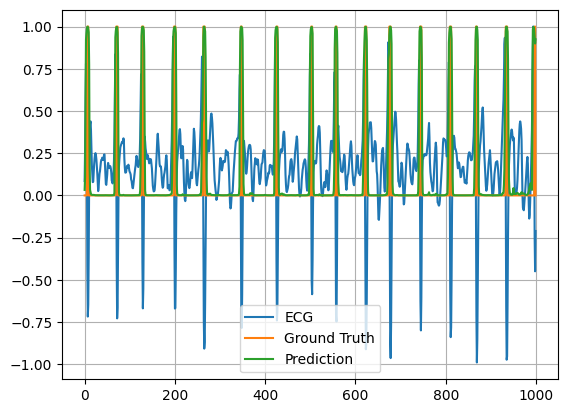

 67%|██████▋   | 267/396 [00:04<00:01, 78.18it/s]

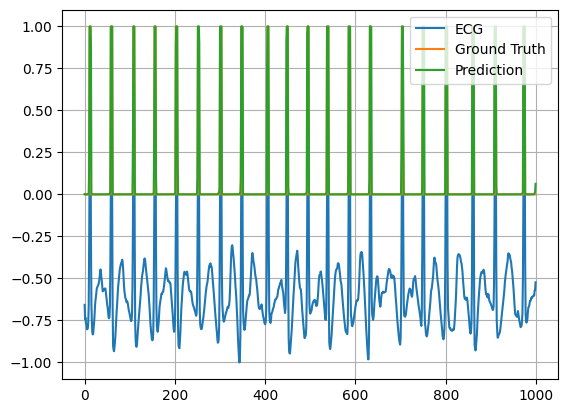

 79%|███████▉  | 312/396 [00:04<00:00, 92.81it/s]

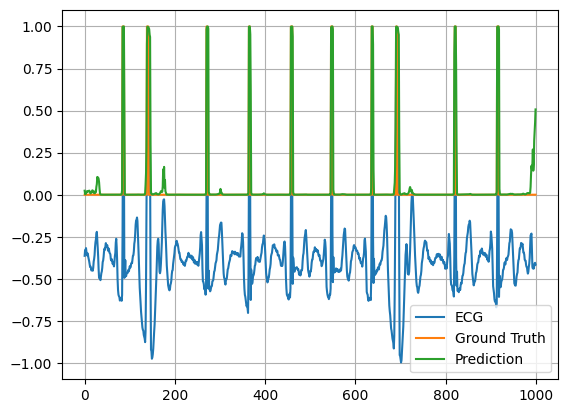

 88%|████████▊ | 350/396 [00:05<00:00, 92.84it/s]

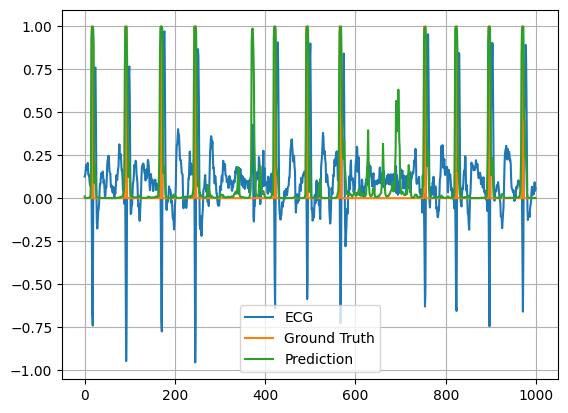

 97%|█████████▋| 386/396 [00:05<00:00, 92.25it/s]

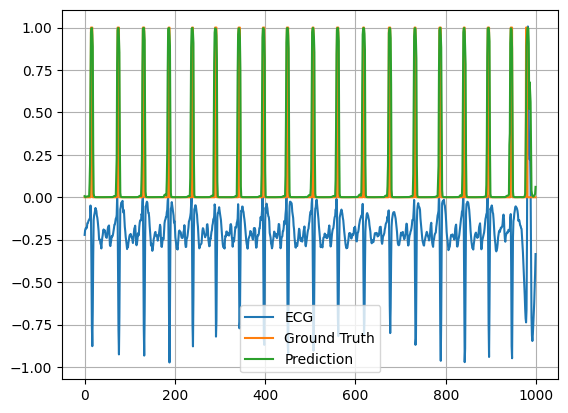

100%|██████████| 396/396 [00:05<00:00, 68.32it/s]



Test Loss: 0.1450
Test Weighted Accuracy: 0.97772
Test F1 Score: 0.71143
Test TPR: 0.99225
Test FPR: 0.03681
Test TNR: 0.96319
Test FNR: 0.00775



In [233]:
torch.save(model, "./checkpoints/lstm/two_bilstm_hidden_size_32_epoch_20_whole_mitbih.pt")
model.test_model(x_test=x_test, y_test=y_test, plot=True)

### Testing with Apnea-ecg ECG recording

In [223]:
path = "E:\\ml-data\\masters-thesis\\physionet.org\\files\\apnea-ecg\\1.0.0\\dataset"
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(path=path, is_validation_set=True)

In [224]:
#x_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_train.npy")), 2)[:10000]
#y_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_train.npy")), 2)[:10000]

x_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_test.npy")), 2)[:10000]
y_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_test.npy")), 2)[:10000]

#x_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_val.npy")), 2)[:10000]
#y_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_val.npy")), 2)[:10000]


  0%|          | 0/1000 [00:00<?, ?it/s]

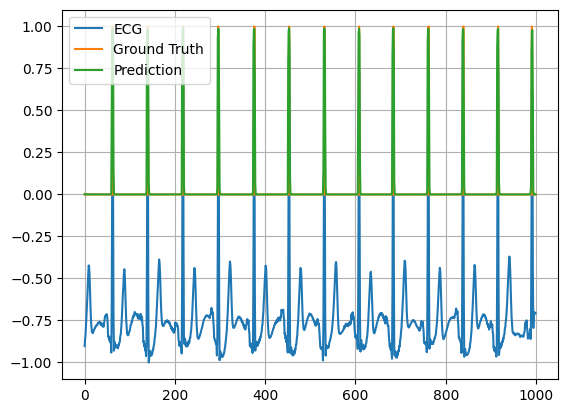

 10%|▉         | 96/1000 [00:01<00:07, 118.94it/s]

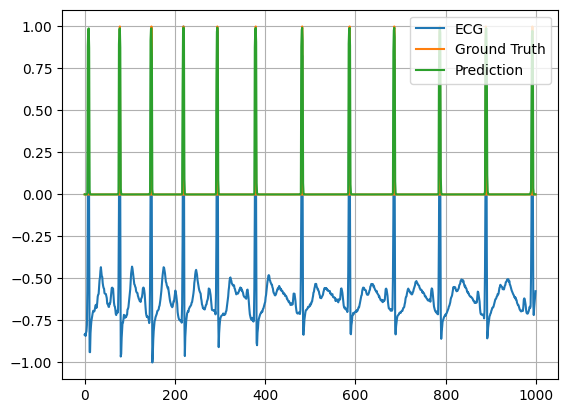

 19%|█▉        | 190/1000 [00:01<00:06, 122.90it/s]

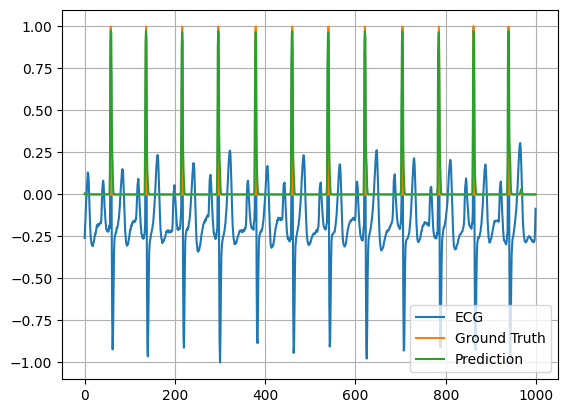

 30%|██▉       | 297/1000 [00:02<00:05, 124.02it/s]

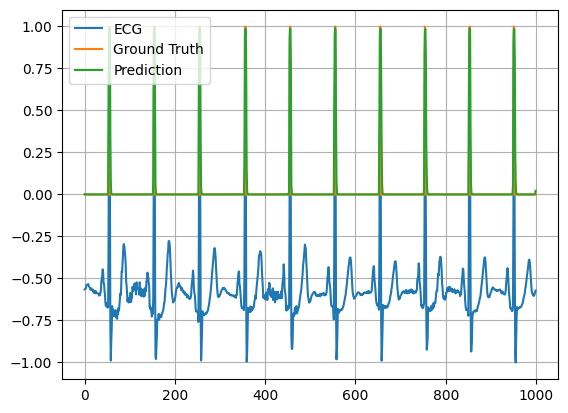

 39%|███▉      | 388/1000 [00:03<00:05, 119.96it/s]

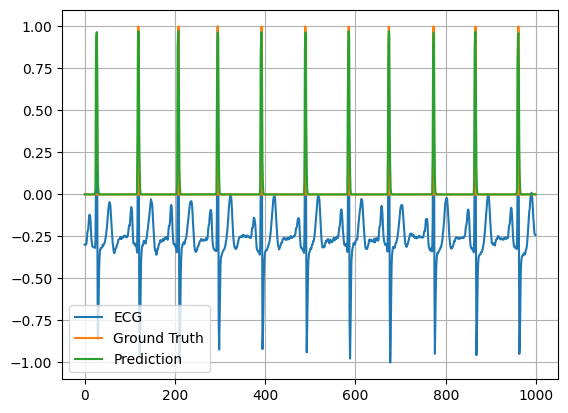

 50%|████▉     | 495/1000 [00:04<00:04, 125.89it/s]

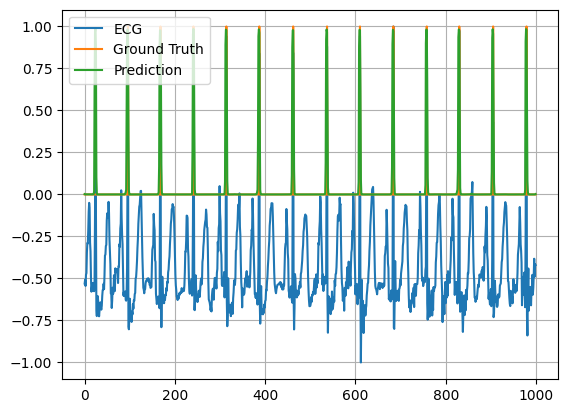

 59%|█████▉    | 588/1000 [00:05<00:03, 120.59it/s]

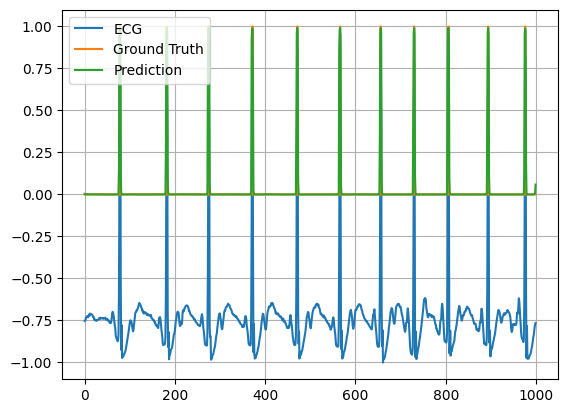

 70%|██████▉   | 698/1000 [00:06<00:02, 125.95it/s]

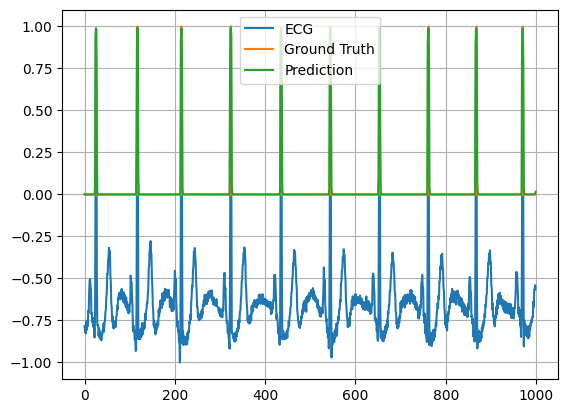

 79%|███████▉  | 788/1000 [00:07<00:01, 121.80it/s]

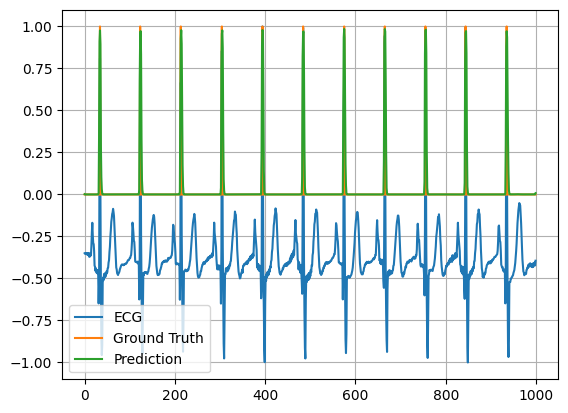

 90%|████████▉ | 896/1000 [00:08<00:00, 127.57it/s]

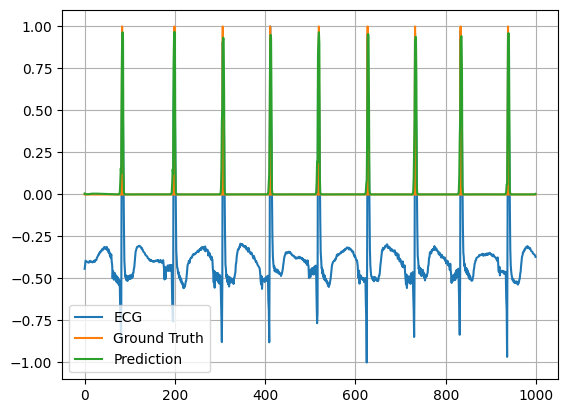

100%|██████████| 1000/1000 [00:09<00:00, 105.74it/s]



Test Loss: 0.0863
Test Weighted Accuracy: 0.93139
Test F1 Score: 0.35913
Test TPR: 0.89682
Test FPR: 0.03404
Test TNR: 0.96596
Test FNR: 0.10318



In [225]:
model.test_model(x_test=x_test, y_test=y_test, plot=True)

In [210]:
temp = x_train.copy()
temp_2 = y_train.copy()

In [211]:
temp = temp.reshape((-1, 50, 3600, 1))
temp_2 = temp_2.reshape((-1, 50, 3600, 1))

In [215]:
ecg = temp[59][2].flatten()
y = temp_2[59][2].flatten()

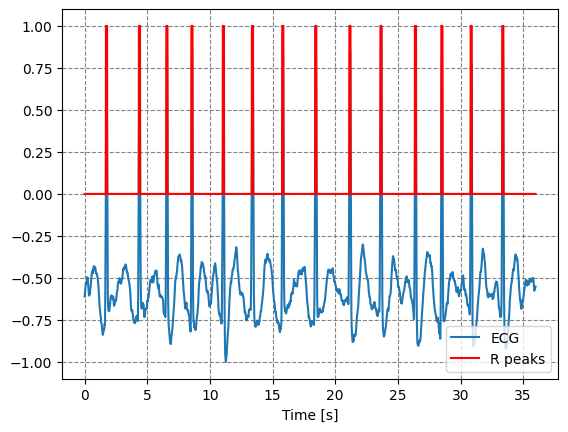

In [216]:
plot_ecg(ecg, y, 100)

In [162]:
ecg = myConv1D(ecg.flatten(), 5, "same")
ecg = resample_signal(ecg, 1000)
r_peaks = downsample_r_peaks_probability(y, 360, 100)

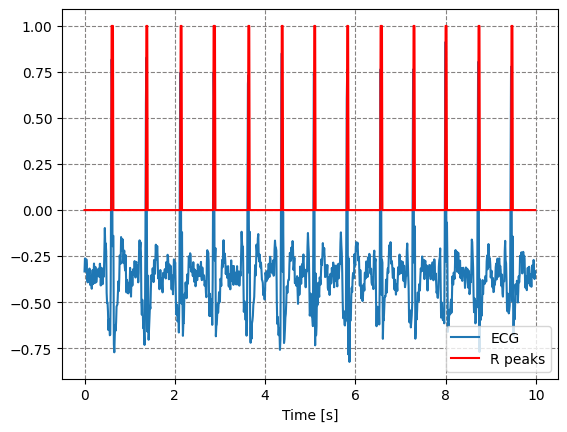

In [163]:
plot_ecg(ecg, r_peaks, 100)